# Imports and Defaults

In [2]:
import json
import os
from collections import namedtuple
from functools import lru_cache
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# sns.set_theme(font_scale=1.6, style="whitegrid")
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
})

seed = 1234
rng = np.random.default_rng(seed)

In [9]:
posterior = "normal50"

# Load Data

In [10]:
fname = f"../../data/{posterior}/baseline"

drghmc_sampler = "adapt_metric=True__damping=0.08__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__step_count_method=const_step_count__step_size_factor=2"
drhmc_sampler = "adapt_metric=True__damping=1.0__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drhmc__step_count_factor=0.9__step_size_factor=2"
nuts_sampler = "adapt_metric=True__metric=identity__sampler_type=nuts"

In [11]:
def get_fname(sampler, chain):
    return os.path.join(fname, sampler, f"metrics__chain={chain}.npz")

def get_chain_data(sampler, chain, downsample=100):
    data = np.load(get_fname(sampler, chain))
    return data["error_param"][::downsample], data["error_param_squared"][::downsample]

In [16]:
@lru_cache(maxsize=3)
def get_data(sampler):
    e1_list, e2_list = [], []
    for chain in range(100):
        error_p1, error_p2 = get_chain_data(sampler, chain) # draws = (n_samples, n_params)
        e1_list.append(error_p1)
        e2_list.append(error_p2)
    
    # do not stack b/c variable len chains
    return e1_list, e2_list

In [17]:
# [chain, samples]
drghmc_e1, drghmc_e2 = get_data(drghmc_sampler)
drhmc_e1, drhmc_e2 = get_data(drhmc_sampler)
nuts_e1, nuts_e2 = get_data(nuts_sampler)

In [18]:
# average over last error in each chain
drghmc_error1 = np.mean([chain[-1] for chain in drghmc_e1])
drhmc_error1 = np.mean([chain[-1] for chain in drhmc_e1])
nuts_error1 = np.mean([chain[-1] for chain in nuts_e1])

In [19]:
print("DRGHMC Error:\t", drghmc_error1)
print("DRHMC Error:\t", drhmc_error1)
print("NUTS Error:\t", nuts_error1)

DRGHMC Error:	 0.04250088297590591
DRHMC Error:	 0.26366936620750636
NUTS Error:	 0.018839124799918908


# Compute True Params from Reference Draws

In [20]:
TrueParams = namedtuple('TrueParams', ['p1_mean', 'p1_std', 'p2_mean', 'p2_std'])

def load_true_params(posterior):
    ref_draws_fname = os.path.join(f"../../posteriors/{posterior}/{posterior}.ref_draws.json.zip")
    with ZipFile(ref_draws_fname) as z:
        with z.open(f"{posterior}.ref_draws.json") as f:
            ref_draws = json.load(f)
    return ref_draws

def compute_true_params(posterior):
    ref_draws_raw = load_true_params(posterior) # list of dicts
    ref_draws = np.array([list(d.values()) for d in ref_draws_raw]) # [num_chains, num_params, num_samples]
    # ref_draws = np.array(list(ref_draws_chains[0].values()))
    tp = TrueParams(
        p1_mean=np.mean(ref_draws, axis=(0, 2)),
        p1_std=np.std(ref_draws, axis=(0, 2)),
        p2_mean=np.mean(ref_draws**2, axis=(0, 2)),
        p2_std=np.std(ref_draws**2, axis=(0, 2))
    )
    del ref_draws, ref_draws_raw
    return tp

In [21]:
tp = compute_true_params(posterior)

here4
here5


# Compute Per-Chain Error

In [22]:
def get_mean(data):
    n = data.shape[0]
    denom = np.arange(1, n+1)[:, None]
    return np.cumsum(data, axis=0) / denom

def get_error(data, true_mean, true_std):
    error = (get_mean(data) - true_mean) / true_std
    return np.linalg.norm(error, axis=1, ord=np.inf)  # inf norm equivalent to max

In [24]:
# [chains, samples]
drghmc_error = [get_error(data, tp.p1_mean, tp.p1_std) for data in drghmc_data]
drhmc_error = [get_error(data, tp.p1_mean, tp.p1_std) for data in drhmc_data]
nuts_error = [get_error(data, tp.p1_mean, tp.p1_std) for data in nuts_data]

drghmc_error_squared = [get_error(data**2, tp.p2_mean, tp.p2_std) for data in drghmc_data]
drhmc_error_squared = [get_error(data**2, tp.p2_mean, tp.p2_std) for data in drhmc_data]
nuts_error_squared = [get_error(data**2, tp.p2_mean, tp.p2_std) for data in nuts_data]

NameError: name 'drghmc_data' is not defined

# Error vs Grad Evals

In [49]:
# flatten drghmc_error and keep track of chain index
drghmc_error_flat = np.concatenate(drghmc_error)
drhmc_error_flat = np.concatenate(drhmc_error)
nuts_error_flat = np.concatenate(nuts_error)

drghmc_error

drghmc_chain_idx = np.concatenate([np.full_like(e, i) for i, e in enumerate(drghmc_error)])
drhmc_chain_idx = np.concatenate([np.full_like(e, i) for i, e in enumerate(drhmc_error)])
nuts_chain_idx = np.concatenate([np.full_like(e, i) for i, e in enumerate(nuts_error)])

# Final Error Box Plot

In [45]:
# get last error only
drghmc_e1 = np.array([chain[-1] for chain in drghmc_error])
drhmc_e1 = np.array([chain[-1] for chain in drhmc_error])
nuts_e1 = np.array([chain[-1] for chain in nuts_error])

drghmc_e2 = np.array([chain[-1] for chain in drghmc_error_squared])
drhmc_e2 = np.array([chain[-1] for chain in drhmc_error_squared])
nuts_e2 = np.array([chain[-1] for chain in nuts_error_squared])

In [25]:
data = {
    "Sampler": ["DR-G-HMC"]*len(drghmc_e1) + ["DR-HMC"]*len(drhmc_e1) + ["NUTS"]*len(nuts_e1),
    "Errors": np.concatenate([drghmc_e1, drhmc_e1, nuts_e1]),
    "Error Squared": np.concatenate([drghmc_e2, drhmc_e2, nuts_e2]),
}

data = pd.DataFrame(data)
data = data.melt(id_vars="Sampler", var_name="Error Type", value_name="Error")
data

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


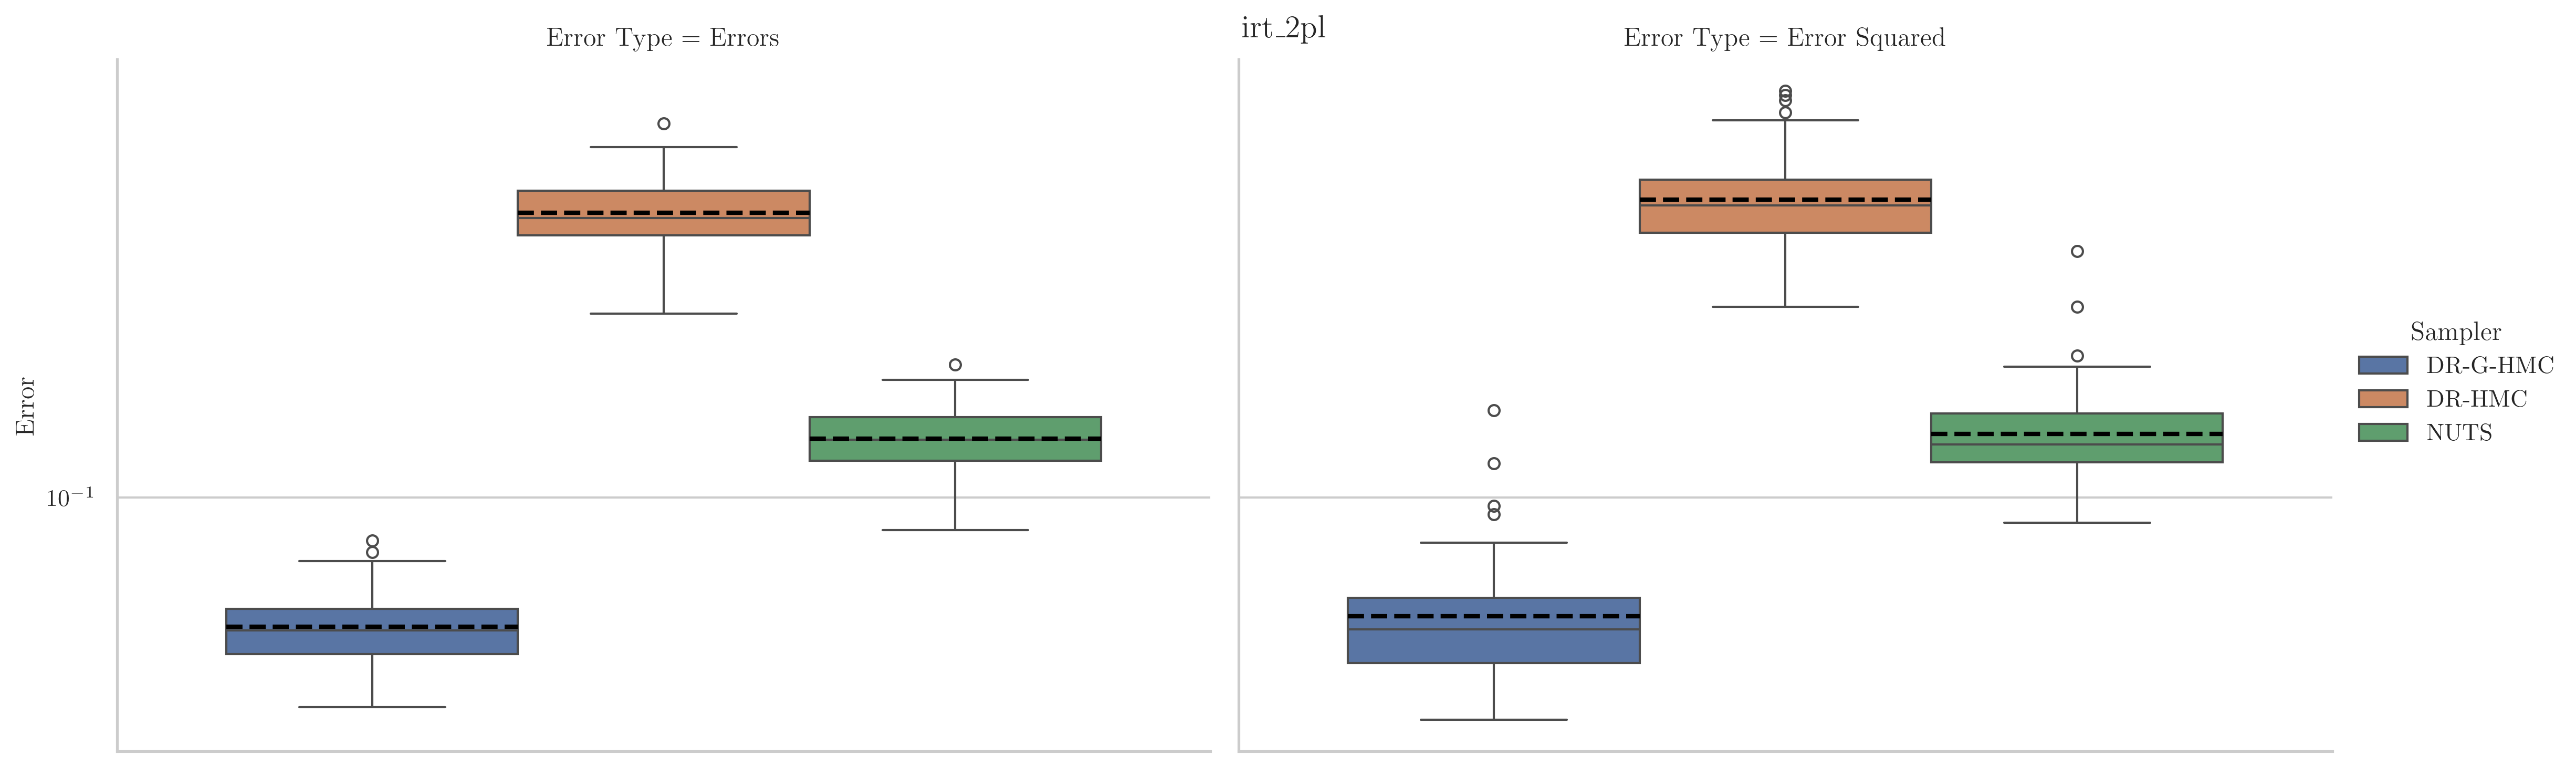

In [47]:
fig = sns.catplot(
    data=data,
    kind="box",
    # x="Sampler",
    y="Error",
    col="Error Type",
    hue="Sampler",
    hue_order=["DR-G-HMC", "DR-HMC", "NUTS"],
    aspect=1.5,
    showmeans=True,
    meanline=True,
    meanprops=dict(linestyle="--", linewidth=2, color="black"),
)

# show fig
# add title for entire figure
fig.figure.suptitle(f"{posterior}")
fig.set(yscale="log")
plt.show()

In [78]:
# print mean of draws for each dimension
# recall drghmc_data, drhmc_data, nuts_data are lists of numpy arrays
print("\t\tDR-G-HMC\tDR-HMC\t\tNUTS\t\tRef")

drghmc_mean = np.mean([np.mean(data, axis=0) for data in drghmc_data], axis=0)
drhmc_mean = np.mean([np.mean(data, axis=0) for data in drhmc_data], axis=0)
nuts_mean = np.mean([np.mean(data, axis=0) for data in nuts_data], axis=0)
ref_mean = tp.p1_mean

mean_iter = zip(drghmc_mean, drhmc_mean, nuts_mean, ref_mean)
for idx, (m1, m2, m3, m4) in enumerate(mean_iter):
    # print(f"Param {idx+1}:\t{m1:.4f}\t\t{m2:.4f}\t\t{m3:.4f}\t\t{m4:.4f}")
    m1_diff, m2_diff, m3_diff = np.abs(m1 - m4) / tp.p1_std[idx], np.abs(m2 - m4) / tp.p1_std[idx], np.abs(m3 - m4) / tp.p1_std[idx]
    print(f"Diff {idx + 1}: \t{m1_diff:.4f}\t\t{m2_diff:.4f}\t\t{m3_diff:.4f}")


		DR-G-HMC	DR-HMC		NUTS		Ref
Diff 1: 	0.0034		0.0232		0.0087
Diff 2: 	0.0007		0.0104		0.0080
Diff 3: 	0.0007		0.0111		0.0051
Diff 4: 	0.0005		0.0010		0.0121
Diff 5: 	0.0003		0.0117		0.0046
Diff 6: 	0.0005		0.0123		0.0108
Diff 7: 	0.0047		0.0074		0.0034
Diff 8: 	0.0039		0.0213		0.0027
Diff 9: 	0.0015		0.0380		0.0127
Diff 10: 	0.0006		0.0055		0.0111
Diff 11: 	0.0007		0.0038		0.0011
Diff 12: 	0.0011		0.0173		0.0030
Diff 13: 	0.0032		0.0172		0.0031
Diff 14: 	0.0039		0.0164		0.0075
Diff 15: 	0.0007		0.0088		0.0027
Diff 16: 	0.0022		0.0173		0.0011
Diff 17: 	0.0035		0.0173		0.0003
Diff 18: 	0.0026		0.0072		0.0016
Diff 19: 	0.0036		0.0173		0.0095
Diff 20: 	0.0008		0.0001		0.0031
Diff 21: 	0.0019		0.0239		0.0059
Diff 22: 	0.0047		0.0036		0.0028
Diff 23: 	0.0009		0.0119		0.0002
Diff 24: 	0.0017		0.0083		0.0012
Diff 25: 	0.0008		0.0216		0.0044
Diff 26: 	0.0004		0.0147		0.0012
Diff 27: 	0.0010		0.0071		0.0023
Diff 28: 	0.0010		0.0255		0.0001
Diff 29: 	0.0011		0.0367		0.0045
Diff 30: 	0.0016		0.040